In [2]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np 
from openbb import obb
from datetime import date
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
from datetime import date
import warnings
warnings.filterwarnings('ignore')

obb.user.preferences.output_type = 'dataframe'

In [3]:
tickers = [
    "AAPL", # Apple Inc.
    "MSFT",  # Microsoft Corporation
    "GOOGL", # Alphabet Inc. (Class A)
    "AMZN",  # Amazon.com Inc.
    "META",  # Meta Platforms Inc.
    "NVDA",  # NVIDIA Corporation
    "TSLA",  # Tesla Inc.
    "JPM",   # JPMorgan Chase & Co.
    "V",     # Visa Inc.
    "AMD", # AMD 
    "KO", # Coca Cola
    "SBUX", #Starbucks
    "PEP", # Pepsi
    "GE", # General Electric
    "GM", # General Motors
    "NFLX", # Netflix
    "RBLX", # Roblox
    "SONY", # Sony
    "WMT", # Walmart
    "IBM", # IBM
    "TGT", # target
    "COF" ,# Capital One,
    "PLTR", # Palantir,
    "MELI", # MercadoLibre
    "ROAD", #Construction
    "QUBT", # Quantum Computing
    "SHOP", # Shopify
    "ADBE" ,# Adobe
    "BRK-B",# berkshire hathaway
    "OKLO", # Oklo Inc
    "SMR", # Nuscale Power Corp
    "HOOD", # Robinhood 
    "GIL", # gildan
    "SPY" # SP 500  

]
end = pd.Timestamp.today().normalize()


In [4]:
def get_historical_Data(tickers):
    end_date = date.today().isoformat() 
    names = list()
    mapp = {}
    for i in tickers:
        data = pd.DataFrame(yf.download(i, end=end_date, progress=False))
        columns = data.columns
        
        data.columns = [i for i,stock in columns]
        mapp[i] = data
    

    return mapp

portolio = ['AAPL', 'NVDA', 'SBUX', 'GE','SPY']

def combined_portfolio_data(stock_portfolio):
    data = yf.download(stock_portfolio, end = end).Close

    return data.dropna()

In [5]:
porfolio_data = combined_portfolio_data(portolio) 

total_porfolio_returns = porfolio_data.pct_change().sum(axis = 1)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed


In [6]:
start = str(porfolio_data.index[0]).split(" ")[0]

In [7]:
total_porfolio_returns.name = 'porfolio_returns'


# market - risk free rate, small minus big stocks, high minus low, risk free
fama_french = web.DataReader('F-F_Research_Data_Factors_daily',
                             'famafrench',
                             start = start,
                             end = end)[0]

In [8]:
together = pd.concat([fama_french, total_porfolio_returns], axis = 1).dropna()

excess_returns = together.porfolio_returns - together.RF
excess_returns.name = "Excess Returns"

excess_returns

together

,Mkt-RF,SMB,HML,RF,porfolio_returns
Date,,,,,
1999-01-22,-0.66,0.41,0.15,0.02,0.000000
1999-01-25,0.67,-0.95,0.09,0.02,0.157913
1999-01-26,1.39,-0.25,-1.12,0.02,0.000305
1999-01-27,-0.74,0.10,-0.64,0.02,-0.068235
1999-01-28,1.63,-1.07,-0.50,0.02,0.052719
...,...,...,...,...,...
2025-09-24,-0.34,-0.36,0.99,0.02,-0.053707
2025-09-25,-0.58,-0.77,0.55,0.02,0.001917
2025-09-26,0.60,0.28,0.45,0.02,-0.009598


In [9]:
x  = together[['SMB', 'HML']]
x = sm.add_constant(x)

model = sm.OLS(excess_returns, x).fit()
hedge_weights = -model.params[1:]

-model.params[1:] * 100

SMB   -1.700654
HML    0.859030
dtype: float64

In [10]:
hedge_portfolio = (together[['SMB', 'HML']] @ hedge_weights).dropna()

hedge_portfolio_returns = total_porfolio_returns.loc[hedge_portfolio.index] + hedge_portfolio

hedge = pd.DataFrame({
    'unhedged_returns' : total_porfolio_returns.loc[hedge_portfolio_returns.index], 
    'hedged_returns' : hedge_portfolio_returns})

import math
sharpe_ratio = pd.DataFrame(hedge.mean() / hedge.std() * math.sqrt(252), columns = ['Sharpe Ratio of Full Porfolio'])

sharpe_ratio

,Sharpe Ratio of Full Porfolio
unhedged_returns,0.900253
hedged_returns,0.903015


In [11]:
data = get_historical_Data(tickers)


In [12]:
apple = data['AAPL']


In [32]:
spy_og = data['SPY']

spy = spy_og[spy_og.index > start]


spy_returns = pd.DataFrame(np.log(spy['Close'] /spy['Close'].shift(1)).dropna())

beta_og_spy = spy_og

if not beta_og_spy.empty:
        beta_og_spy['returns'] = np.log(beta_og_spy['Close'] / beta_og_spy['Close'].shift(1))
        start = pd.Timestamp.today().normalize().replace(year=end.year - 5, month=1, day=1)
        spy_beta = beta_og_spy[beta_og_spy.index > start]
        spy_beta = spy_beta.dropna()
        spy_beta = spy_beta['returns']
spy_beta

Date
2020-01-02    0.009308
2020-01-03   -0.007601
2020-01-06    0.003808
2020-01-07   -0.002816
2020-01-08    0.005315
                ...   
2025-11-17   -0.009360
2025-11-18   -0.008433
2025-11-19    0.003856
2025-11-20   -0.015360
2025-11-21    0.009912
Name: returns, Length: 1482, dtype: float64

In [34]:
start = pd.Timestamp.today().normalize().replace(year=end.year - 5, month=1, day=1)

apple = data['AAPL'][data['AAPL'].index > start]


apple

,Close,High,Low,Open,Volume,returns
Date,,,,,,
2020-01-02,72.468262,72.528582,71.223259,71.476600,135480400,0.022560
2020-01-03,71.763733,72.523762,71.539345,71.696175,146322800,-0.009769
2020-01-06,72.335564,72.374169,70.634547,70.885479,118387200,0.007937
2020-01-07,71.995377,72.600983,71.775811,72.345227,108872000,-0.004714
2020-01-08,73.153496,73.455095,71.698581,71.698581,132079200,0.015958
...,...,...,...,...,...,...
2025-11-17,267.459991,270.489990,265.730011,268.820007,45018300,-0.018338
2025-11-18,267.440002,270.709991,265.320007,269.989990,45677300,-0.000075
2025-11-19,268.559998,272.209991,265.500000,265.529999,40424500,0.004179


In [44]:
# stock_info #
end = pd.Timestamp.today().normalize()
start = end - pd.DateOffset(years=10)

# look to webscrape this metric from fred 
# https://fred.stlouisfed.org/series/DGS10
risk_free = .00411
adjustment_factor = 0.0


sharpe_dictionary = {}
sortino_ratio_dictionary = {}
betas = {}
alphas = {}

# alpha is defined as


for stock, stock_data in data.items():
    stock_data['returns'] = np.log(stock_data['Close'] / stock_data['Close'].shift(1))
    stock_data = stock_data.dropna()
    
    # needed for declaring a beta
    idx = stock_data.index.slice_indexer(start=start, end=end)
    last_ten_years_data = stock_data.iloc[idx]
    YoY_cagr_ten = (last_ten_years_data['Close'].iloc[-1] / last_ten_years_data['Close'].iloc[0]) ** (1/10) - 1 
    sigma =  last_ten_years_data['returns'].std(ddof = 0) * np.sqrt(252)
    sharpe_ratio_ten_year = (YoY_cagr_ten - risk_free)  / (sigma)
    sharpe_dictionary[stock] = {"Sharpe Ratio Ten Year" : sharpe_ratio_ten_year}
    
    # sortino ratio
    returns_risk_adj = np.asanyarray(stock_data['returns'].dropna() - adjustment_factor)
    average_annual_return = returns_risk_adj.mean() * 252
    downside_difference = np.clip(returns_risk_adj, np.NINF, 0)
    np.square(downside_difference, out = downside_difference)
    annualized_downside_deviation = np.sqrt(downside_difference.mean()) * np.sqrt(252)
    sortino_ratio = average_annual_return / annualized_downside_deviation
    sortino_ratio_dictionary[stock] = {"Sortino Ratio" : sortino_ratio}


    # beta for each stock
    start_beta = pd.Timestamp.today().normalize().replace(year=end.year - 5, month=1, day=1)

    if stock == 'SPY':
        continue
    start = pd.Timestamp.today().normalize().replace(year=end.year - 5, month=1, day=1)

    stock_return = stock_data['returns']

    
    starting_point_returns = stock_return[stock_return.index > start]


    if len(starting_point_returns.index) != len(spy_beta.index):
        betas[stock] = np.nan
        continue

        
    co_variance = np.cov(starting_point_returns, spy_beta)[0,1]

    print(co_variance)
    
    beta = co_variance / np.var(spy_beta)
    betas[stock] = {"Beta" : beta} 

    ## alpha comparative with betas

    five_year_return = starting_point_returns[0] / starting_point_returns[-1]  

    five_year_market_return = spy_beta[0] / spy_beta[-1]

    alpha = five_year_return - (risk_free + (beta * (five_year_market_return -  risk_free)))

    alphas[stock] = {'Alphas': alpha}

    

df_sharpe = pd.DataFrame(sharpe_dictionary)
df_sortino = pd.DataFrame(sortino_ratio_dictionary)
df_beta = pd.DataFrame(betas)
df_alpha = pd.DataFrame(alphas)


# df_beta


df_final = pd.concat([df_sharpe, df_sortino, df_beta,df_alpha], axis = 0)

0.0002088665500774458
0.0001991377877014928
0.00019665596467616716
0.0001973936691776888
0.00023245561637500186
0.0003123457645383751
0.0002971822177841294
0.00018672840757130363
0.00017214318315981266
0.00028637921819141867
9.590112977002031e-05
0.00018528538087459584
0.00010244378471646388
0.00020112835897795686
0.00021400588398898346
0.00017741553993245882
0.00014927542469216396
8.375593680237149e-05
0.00013703690069407924
0.00014916908832700274
0.00025578551300494887
0.00024436202721215926
0.0002083841893825813
0.00023283646419580649
0.00030724779629894705
0.00021232867840335085
0.00013413237506820145
0.00018688277916514208


In [46]:
df_final

,AAPL,MSFT,GOOGL,AMZN,META,NVDA,TSLA,JPM,V,AMD,...,ROAD,QUBT,SHOP,ADBE,BRK-B,OKLO,SMR,HOOD,GIL,SPY
Sharpe Ratio Ten Year,0.881656,0.389006,0.479005,0.233865,0.239097,0.753417,0.441382,0.291310,0.205978,0.277043,...,0.398317,0.093032,0.204707,-0.018918,0.366161,0.279380,0.059196,0.156612,0.189383,0.374058
Sortino Ratio,0.549738,0.977354,1.088455,0.741004,0.726760,0.770570,0.905422,0.509504,0.935666,0.217340,...,0.833720,-0.136741,1.050169,0.555871,0.702045,0.847323,0.240202,0.527502,0.653820,0.754345
Beta,1.201773,1.145796,1.131516,1.135760,1.337499,1.797170,1.709922,1.074395,0.990475,1.647764,...,1.198998,1.339691,1.767837,1.221693,0.771769,NaN,NaN,NaN,1.075283,NaN
Alphas,0.029764,-2.457329,-0.438059,0.585857,1.278101,-3.666164,-4.273230,-10.990134,0.384992,-7.789189,...,-4.270900,1.200675,-0.510888,-0.770895,0.704514,NaN,NaN,NaN,-0.473886,NaN


$$
\text{Sharpe Ratio} = \frac{\mathbb{E}\!\left[R_p - R_f\right]}{\sigma\!\left(R_p\right)}
$$

In [48]:
def sharpe_ratio(returns, adjustment_factor=0.0):
    returns_risk_adj = returns - adjustment_factor
    return (
        returns_risk_adj.mean() / returns_risk_adj.std()
    ) * np.sqrt(252)

<Axes: xlabel='Date'>

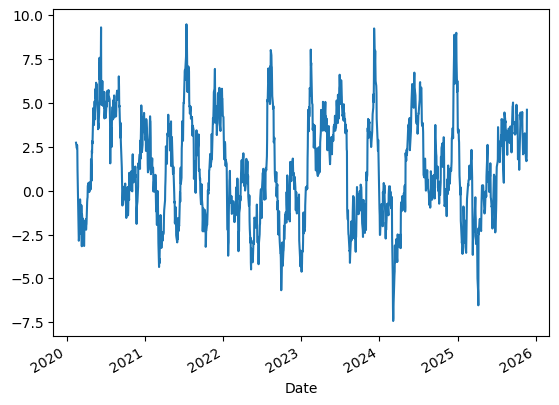

In [50]:
apples_sharpe = sharpe_ratio(apple)

apples_sharpe

test = apple['Close'].pct_change().rolling(30).apply(sharpe_ratio)


test.plot()

## How would I calculate Beta

$$
\beta = \frac{\text{Cov}(R_i, R_m)}{\text{Var}(R_m)}
$$


In [75]:
# # def alpha_beta(sales):

# spy = get_historical_Data(['SPY'])['SPY']
# start_beta = pd.Timestamp.today().normalize().replace(year=end.year - 5, month=1, day=1)

# spy['returns'] =  spy['Close'].pct_change()
# spy['log_returns'] =  np.log(spy['Close'] / spy['Close'].shift(1))
# # spy = spy.dropna()

# # # spy_log_returns
# # spy_ = spy[spy_log_returns.index > start_beta]['log_returns']

# # spy_returns

# spy

# apple

# spy
# spy = spy['log_returns']
# # apple = apple['log_returns']
# apple= data['AAPL']
# apple_log_returns = apple['log_returns']
# spy

# apple = pd.DataFrame(apple_log_returns)
# spy =pd.DataFrame(spy)

# together  = pd.concat([apple, spy], axis = 1)

# together.dropna()

In [242]:
import requests

# url = "https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value=all"

# # Read tables from the page
# tables = pd.read_html(url)

# # Usually the first table is the main data
# df = tables[0]

# # Preview
# print(df.head())


url = "https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value=2025"


test = pd.read_html(url)[0]

# def fetching_treasury_data():
    

In [264]:

test.columns

needed = []
for column in test.columns:
    column = column.title().strip()
    if column not in ('5 Yr', 'Date'):
        continue
        print(column)
    needed.append(column)
    new = test[needed]
    new['Date'] = pd.to_datetime(new['Date'])

new
avg_by_calendar_month = (
    new.assign(month=new['Date'].dt.month)
      .groupby('month', sort=True)['5 Yr']
      .mean()
      .rename_axis('month')
      .reset_index()
)



# avg_by_calendar_month

# jan_2025 = new[(new['Date'] >= pd.Timestamp('2025-01-01')) & (new['Date'] < pd.Timestamp('2025-02-01'))]

# jan_2025['5 Yr'].mean()

avg_by_calendar_month

,month,5 Yr
0,1,4.429048
1,2,4.280526
2,3,4.043333
3,4,3.913333
4,5,4.023333
5,6,3.963000
6,7,3.948636
7,8,3.786190
8,9,3.662381
9,10,3.648636


In [66]:
df.columns
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

KeyError: 'Date'

In [68]:
df = df.drop(columns=[col for col in df.columns if col != '5 Yr'])
df

,5 Yr
Date,
1990-01-02,7.87
1990-01-03,7.92
1990-01-04,7.91
1990-01-05,7.92
1990-01-08,7.92
...,...
1991-03-08,7.77
1991-03-11,7.71
1991-03-12,7.74
